<a href="https://colab.research.google.com/github/nematatu/Colab-Python/blob/master/kasoon_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install -q bing_image_downloader
!pip install -q google-cloud-vision
!pip install -q tensorflow
!pip install -q Pillow

In [37]:
from bing_image_downloader import downloader
from google.cloud import vision
import google.cloud.vision_v1.types as types
from PIL import Image as PILImage
from PIL import ImageOps
import os
import random
import shutil
import tensorflow as tf

from google.colab import drive
from IPython.display import Image,display_jpeg

In [38]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
!readlink -f drive/MyDrive/Colab\ Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json

/content/drive/MyDrive/Colab Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json


In [40]:
google_auth_path='/content/drive/MyDrive/Colab\ Notebooks/kasoon_colab/fluted-oath-407809-b8c332499f57.json'


In [41]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] ='/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json'


In [42]:
from bing_image_downloader import downloader
query_string = input("input:")

downloader.download(query_string,output_dir=r'./img',adult_filter_off=False,timeout=120,verbose= True)

input:伊織もえ
[%] Downloading Images to /content/img/伊織もえ


[!!]Indexing page: 1

[%] Indexed 35 Images on Page 1.


[%] Downloading Image #1 from https://i.pinimg.com/originals/ef/39/db/ef39db5d729414bc7c59dffcf7e4171d.jpg
[%] File Downloaded !

[%] Downloading Image #2 from https://pbs.twimg.com/media/Dgi78bGV4AEJ400.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://exweb.ismcdn.jp/mwimgs/f/e/1200wm/img_fed4e4b02e0f44ed1ffa40bf09648c3f475088.jpg
[%] File Downloaded !

[%] Downloading Image #4 from http://intervalues3.com/i/iorimoe110.jpg
[Error]Invalid image, not saving http://intervalues3.com/i/iorimoe110.jpg

[!] Issue getting: http://intervalues3.com/i/iorimoe110.jpg
[!] Error:: Invalid image, not saving http://intervalues3.com/i/iorimoe110.jpg

[%] Downloading Image #4 from https://pbs.twimg.com/media/D9QpUZEUwAA_TPB.jpg:large
[%] File Downloaded !

[%] Downloading Image #5 from https://pbs.twimg.com/media/CmvmaHfUcAA6oBI.jpg:large
[%] File Downloaded !

[%] Downloadi

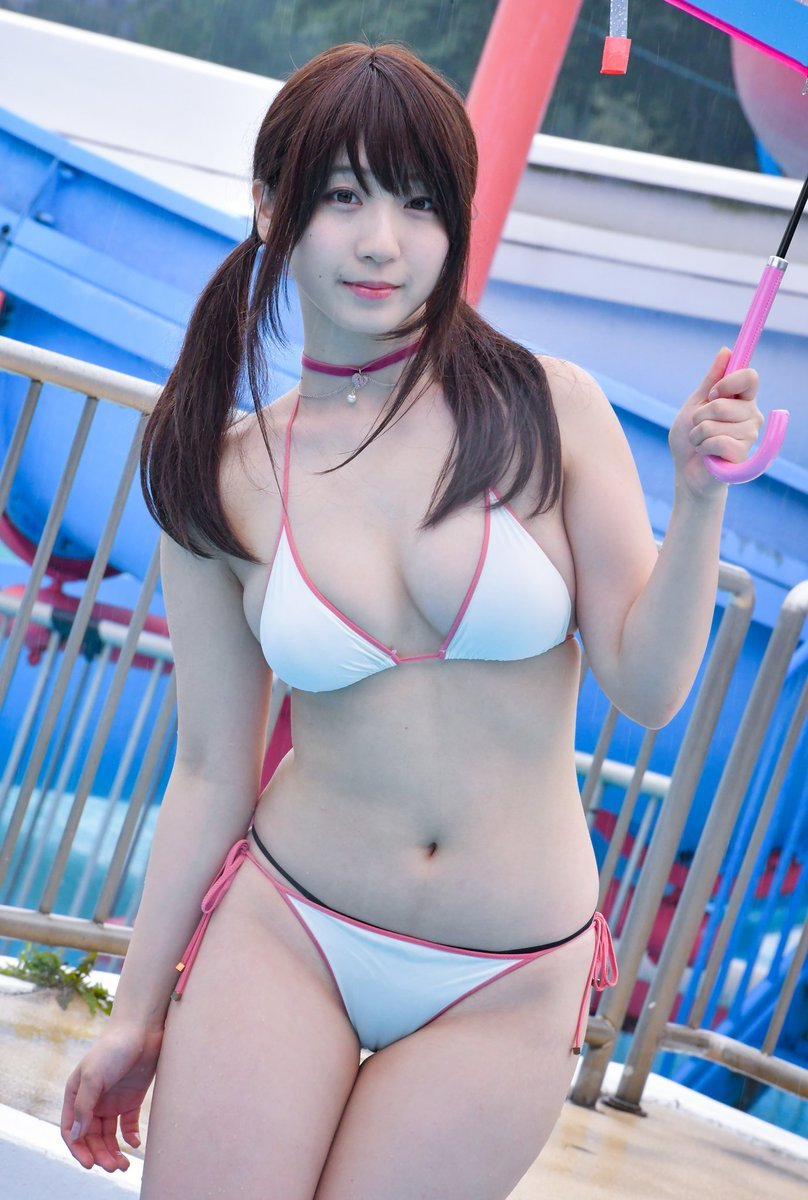

In [44]:
display_jpeg(Image(f'img/{query_string}/Image_10.jpg'))

In [45]:
#def: 顔の検知
def detect_face(image_path):
    client=vision.ImageAnnotatorClient()
    #コードブロックが終わったら自動でfileが閉じる
    #メモリの効率化
    #引数で取ったiamge_pathを'rb'バイナリファイルを読み込む
    with open(image_path, 'rb') as file:
        #読み込んだバイナリファイルを画像形式に変換している
        image=types.Image(content=file.read())
        #GCV APIのface_detection()を使って画像内の顔を検出する
        #そのうち、顔の情報を含むface_annotationsオブジェクトを返す
        annotations=client.face_detection(image=image).face_annotations

    face_boxes=[]

    for annotation in annotations:
        #annotation(顔の情報)の境界ボックス(bounding_poly)の座標情報(vertices)を取得
        #リスト内包表記で、うちx座標のみをリストに格納
        x_s=[vertex.x for vertex in annotation.bounding_poly.vertices]
        y_s=[vertex.y for vertex in annotation.bounding_poly.vertices]
        face_boxes.append((min(x_s),min(y_s),max(x_s),max(y_s)))
    return face_boxes

In [46]:
#def: データセットの分割
train_dir_path='./ds/train'
test_dir_path='./ds/test'

def split_dataset(image_dir_path):
  file_list=os.listdir(image_dir_path)
  random.shuffle(file_list)

  dir_name=image_dir_path.split('/')[-1]
  train_size=int(len(file_list)*0.8)

  os.mkdir('./ds')
  os.mkdir(train_dir_path)
  os.mkdir(test_dir_path)
  os.mkdir(os.path.join(test_dir_path,dir_name))
  os.mkdir(os.path.join(train_dir_path,dir_name))
  for i, file in enumerate(file_list):
        if i < train_size:
            shutil.copy(os.path.join(image_dir_path, file), os.path.join(train_dir_path,dir_name, file))
        else:
            shutil.copy(os.path.join(image_dir_path, file), os.path.join(test_dir_path, dir_name,file))


In [47]:
!printenv GOOGLE_APPLICATION_CREDENTIALS
#/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json

/content/drive/MyDrive/開発/kasoon/fluted-oath-407809-b8c332499f57.json


In [48]:
#body
max_margin=0.2
image_dir_path=os.path.join('./img',query_string)
file_list=os.listdir(image_dir_path)
image_size=(128,128)

for img in file_list:
    new_img=os.path.join(image_dir_path,img)
    target_name=image_dir_path.split('/')[-1]
    print(new_img)

    if img.endswith('.jpg') or img.endswith('.png') or img.endswith('.jpeg'):
        #faces=img+'_face'
        #GoogleDriveのパスを空白を含めないディレクトリに変更したら行けた
        faces=detect_face(new_img)

        if len(faces)>0:
            #PILライブラリのImage.open()で画像を開く
            #from PIL import Image as PILImageとしたらいけた
            #恐らく、GoogleColab内でImageという変数が重複してる
            image=PILImage.open(new_img).convert('RGB')

            x1,y1,x2,y2=faces[0]
            w=x2-x1
            h=y2-y1

            spaces_x = min(x1, image.width - x2, int(float(w) * max_margin))
            spaces_y = min(y1,image.height-y2,int(float(h)*max_margin))
            margin=min(spaces_x,spaces_y)

            cropped_img=image.crop((
                x1-margin,
                y1-margin,
                x2+margin,
                y2+margin
            ))
            #ImageOps:切り取り
            cropped_img=ImageOps.contain(cropped_img,image_size)

            directory='face_cropped'
            new_directory=os.path.join('./img',directory,target_name)
            if not os.path.exists(new_directory):
                os.mkdir(new_directory)

            cropped_img.save(os.path.join(new_directory,f'cropped_{img}'))

split_dataset(os.path.join('./img','face_cropped',image_dir_path.split('/')[-1]))



./img/伊織もえ/Image_49.jpg
./img/伊織もえ/Image_54.jpg
./img/伊織もえ/Image_77.jpg
./img/伊織もえ/Image_13.jpg
./img/伊織もえ/Image_66.jpg
./img/伊織もえ/Image_47.jpg
./img/伊織もえ/Image_50.jpg
./img/伊織もえ/Image_27.jpg
./img/伊織もえ/Image_71.jpg
./img/伊織もえ/Image_76.jpg
./img/伊織もえ/Image_45.jpg
./img/伊織もえ/Image_69.jpg
./img/伊織もえ/Image_73.jpg
./img/伊織もえ/Image_34.jpg
./img/伊織もえ/Image_21.jpg
./img/伊織もえ/Image_30.jpg
./img/伊織もえ/Image_59.jpg
./img/伊織もえ/Image_14.jpg
./img/伊織もえ/Image_42.jpg
./img/伊織もえ/Image_1.jpg
./img/伊織もえ/Image_74.jpg
./img/伊織もえ/Image_72.jpg
./img/伊織もえ/Image_70.jpg
./img/伊織もえ/Image_38.jpg
./img/伊織もえ/Image_32.jpg
./img/伊織もえ/Image_12.jpg
./img/伊織もえ/Image_3.jpg
./img/伊織もえ/Image_75.jpg
./img/伊織もえ/Image_26.jpg
./img/伊織もえ/Image_61.jpg
./img/伊織もえ/Image_40.jpg
./img/伊織もえ/Image_19.jpg
./img/伊織もえ/Image_2.jpg
./img/伊織もえ/Image_22.jpg
./img/伊織もえ/Image_15.jpg
./img/伊織もえ/Image_79.jpg
./img/伊織もえ/Image_39.jpg
./img/伊織もえ/Image_78.jpg
./img/伊織もえ/Image_51.jpg
./img/伊織もえ/Image_64.jpg
./img/伊織もえ/Image_54.JPG
./img/伊織もえ/Image_53

In [55]:
#モデルを作る
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#ここで伊織もえまで含めない
train_dir_path='./ds/train/'
test_dir_path='./ds/test/'
image_size=(128,128)
batch_size=32

train_datagen=ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=0.5
)

test_datagen=ImageDataGenerator(
    rescale=1./255
)

train_generator=train_datagen.flow_from_directory(
    train_dir_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator=test_datagen.flow_from_directory(
    test_dir_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

Found 64 images belonging to 1 classes.
Found 17 images belonging to 1 classes.
